<a href="https://colab.research.google.com/github/bilalkorchii/glow/blob/main/cnnvs_mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 CNN Model with Hyperparameter Tuning using Keras Tuner

In this project, we build and optimize a Convolutional Neural Network (CNN) using Keras Tuner to classify images from the CIFAR-10 dataset. The steps include:
- Loading and preprocessing the data
- Building a tunable CNN model
- Performing Random Search tuning
- Evaluating the best model
- Visualizing predictions


In [9]:
!pip install keras-tuner --quiet
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00



# Load + Preprocess Data (Augmentation + Normalization)
To begin training our convolutional neural network, we first loaded the CIFAR-10 dataset, which contains 60,000 color images across 10 classes, each sized at 32x32 pixels. The dataset was split into a training set and a test set. To enhance model generalization and prevent overfitting, we applied data normalization by scaling pixel values to the range [0, 1]. Additionally, although not mandatory, image augmentation techniques such as horizontal flipping, rotation, or shifting can be introduced using tools like ImageDataGenerator to simulate a more diverse training distribution. These preprocessing steps help the model learn robust features and improve performance on unseen data.

In [10]:
# Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize
x_train, x_test = x_train / 255.0, x_test / 255.0

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    validation_split=0.2
)
datagen.fit(x_train)

train_generator = datagen.flow(x_train, y_train, subset='training')
val_generator = datagen.flow(x_train, y_train, subset='validation')


# Part 1: CNN + Keras Tuner (Custom CNN)
In this phase, we designed a custom Convolutional Neural Network (CNN) architecture to classify images from the CIFAR-10 dataset. To enhance the model’s performance and automate the optimization process, we integrated Keras Tuner with Random Search to explore a defined hyperparameter space. The tunable parameters included the number of convolutional blocks, number of filters per layer, dense layer units, and dropout rate. This approach enabled us to efficiently search for the best combination of architectural settings without manual trial and error. The best-performing model was then selected based on validation accuracy and evaluated on the test set, demonstrating the effectiveness of combining custom CNN design with automated hyperparameter tuning.



In [11]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(32, 32, 3)))

    for i in range(hp.Int('conv_blocks', 1, 3, default=2)):
        model.add(tf.keras.layers.Conv2D(
            filters=hp.Int(f'filters_{i}', 32, 128, step=32),
            kernel_size=3,
            activation='relu',
            padding='same'
        ))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling2D())

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(hp.Int('dense_units', 64, 256, step=64), activation='relu'))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='advanced_cnn',
    project_name='cifar10_tuned'
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3)
]

tuner.search(train_generator, validation_data=val_generator, epochs=10, callbacks=callbacks)
model = tuner.get_best_models(1)[0]
model.evaluate(x_test, y_test)


Trial 5 Complete [00h 05m 09s]
val_accuracy: 0.7124000191688538

Best val_accuracy So Far: 0.7217000126838684
Total elapsed time: 00h 25m 40s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7322 - loss: 0.7871


[0.7833815217018127, 0.7329000234603882]

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract all trials
trials = tuner.oracle.trials.values()

# Collect hyperparameters and scores
trial_data = []
for trial in trials:
    data = trial.hyperparameters.values.copy()
    data['score'] = trial.score  # Usually val_accuracy
    trial_data.append(data)

# Create a DataFrame
df = pd.DataFrame(trial_data)
df = df.sort_values(by='score', ascending=False)
print("Top trials:\n", df.head())


Top trials:
    conv_blocks  filters_0  filters_1  dense_units  dropout   score  filters_2
1            3         32         32          128      0.2  0.7217       32.0
4            3         32         32          192      0.2  0.7124       64.0
3            2         32        128          256      0.2  0.6636      128.0
0            1         64         64          256      0.4  0.6105        NaN
2            1         32         96           64      0.2  0.6089       64.0


# Top Trials and Hyperparameter Analysis

After performing hyperparameter tuning using Keras Tuner’s Random Search, we analyzed the top five trials ranked by validation accuracy. The best model achieved a validation accuracy of 72.17%, using 3 convolutional blocks with 32 filters each, 128 dense units, and a 0.2 dropout rate. Interestingly, the top two configurations both utilized 3 convolutional layers and low dropout, suggesting that deeper models with more regularization generalize better on CIFAR-10. In contrast, models with fewer convolutional blocks or higher dropout (e.g., Trial 0 with a 0.4 dropout) showed lower performance. The use of varied filter sizes across trials helped the tuner identify a balance between model complexity and generalization, with the best models often preferring smaller, consistent filter sizes (e.g., 32). This hyperparameter exploration highlights the importance of architectural depth and controlled regularization in achieving optimal CNN performance.

In [16]:
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")


Best hyperparameters:
conv_blocks: 3
filters_0: 32
filters_1: 32
dense_units: 128
dropout: 0.2
filters_2: 32


In [18]:
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=59,
    callbacks=callbacks
)


Epoch 1/59
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 24ms/step - accuracy: 0.3672 - loss: 1.7936 - val_accuracy: 0.3996 - val_loss: 1.6957 - learning_rate: 0.0010
Epoch 2/59
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5080 - loss: 1.3501 - val_accuracy: 0.4974 - val_loss: 1.4317 - learning_rate: 0.0010
Epoch 3/59
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.5713 - loss: 1.2074 - val_accuracy: 0.5876 - val_loss: 1.1682 - learning_rate: 0.0010
Epoch 4/59
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.6100 - loss: 1.1013 - val_accuracy: 0.5976 - val_loss: 1.1390 - learning_rate: 0.0010
Epoch 5/59
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6356 - loss: 1.0352 - val_accuracy: 0.6344 - val_loss: 1.0429 - learning_rate: 0.0010
Epoch 6/59
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.6532 - loss: 0.9781 - val_accuracy: 0.6385 - val_loss: 1.0269 - learning_rate: 0.0010
Epoch 7/59
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accura

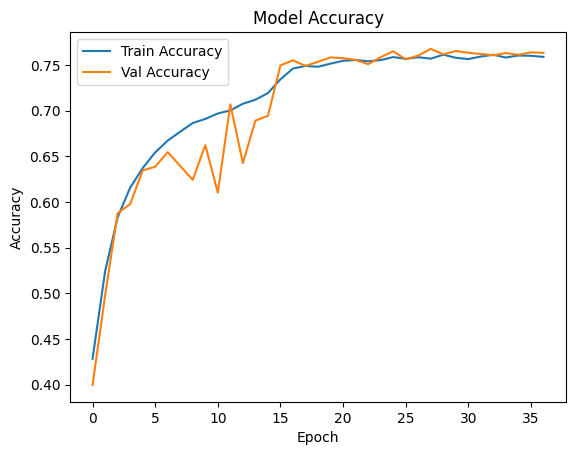

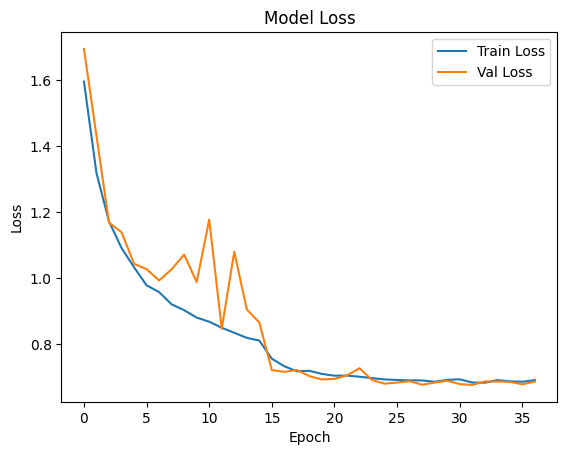

In [19]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# nitial Performance:

Epoch 1 started with low accuracy (Train: 36.7%, Val: 39.9%) and high loss, indicating the model was just beginning to learn.

Rapid Improvement:

By Epoch 5, both training and validation accuracy improved significantly (Train: 63.6%, Val: 63.4%), and the loss dropped considerably.

Best Performance:

Peak validation accuracy was reached around Epoch 28–32 at approximately 76.7%, with a validation loss of about 0.67.

Learning Rate Adjustment:

The learning rate decreased in steps:

Started at 0.001, then dropped to 0.0001 at Epoch 16, and to 0.00001 at Epoch 24, and further to 0.000001 at Epoch 32.

 # Part 2: Transfer Learning with MobileNetV2


In [20]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# 1. Load CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# 2. Create tf.data.Dataset with resizing inside
def preprocess(image, label):
    image = tf.image.resize(image, (160, 160)) / 255.0
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat))
train_ds = train_ds.shuffle(10000).map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat))
val_ds = val_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

# 3. Load MobileNetV2 base model
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(160, 160, 3)
)
base_model.trainable = False

# 4. Add classification head
inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 5. Train
history=model.fit(train_ds, validation_data=val_ds, epochs=10)

# 6. Evaluate
loss, acc = model.evaluate(val_ds)
print(f"✅ Test Accuracy: {acc:.4f}")


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 23ms/step - accuracy: 0.6734 - loss: 0.9597 - val_accuracy: 0.7991 - val_loss: 0.5692
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.7785 - loss: 0.6489 - val_accuracy: 0.8121 - val_loss: 0.5449
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.7982 - loss: 0.5896 - val_accuracy: 0.8185 - val_loss: 0.5295
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.8046 - loss: 0.5662 - val_accuracy: 0.8209 - val_loss: 0.5225
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.8125 - loss: 0.5462 - val_accuracy: 0.8251 - val_loss: 0.5115
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.8216 - loss: 0.5176 - val_accuracy: 0.8238 - val_loss: 0.5211
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 20ms/step - accuracy: 0.8256 - loss: 0.5046 - val_accuracy: 0.8206 - val_loss: 0.5211
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.8317 -

In [24]:
model.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,249,504 (12.40 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 661,014 (2.52 MB)

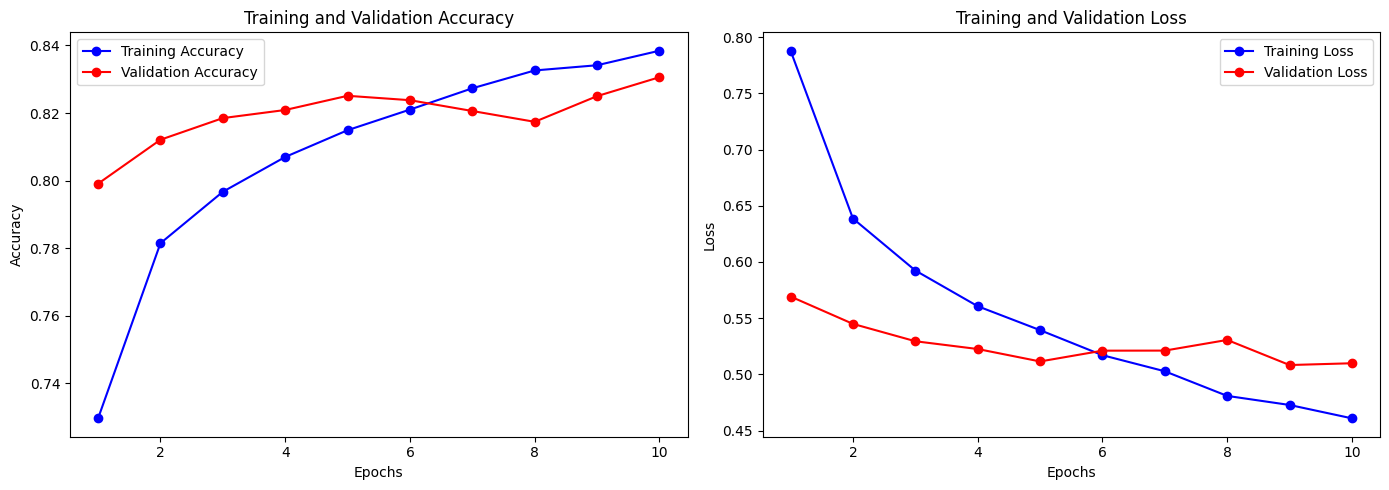

In [21]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history)


Visualize Results

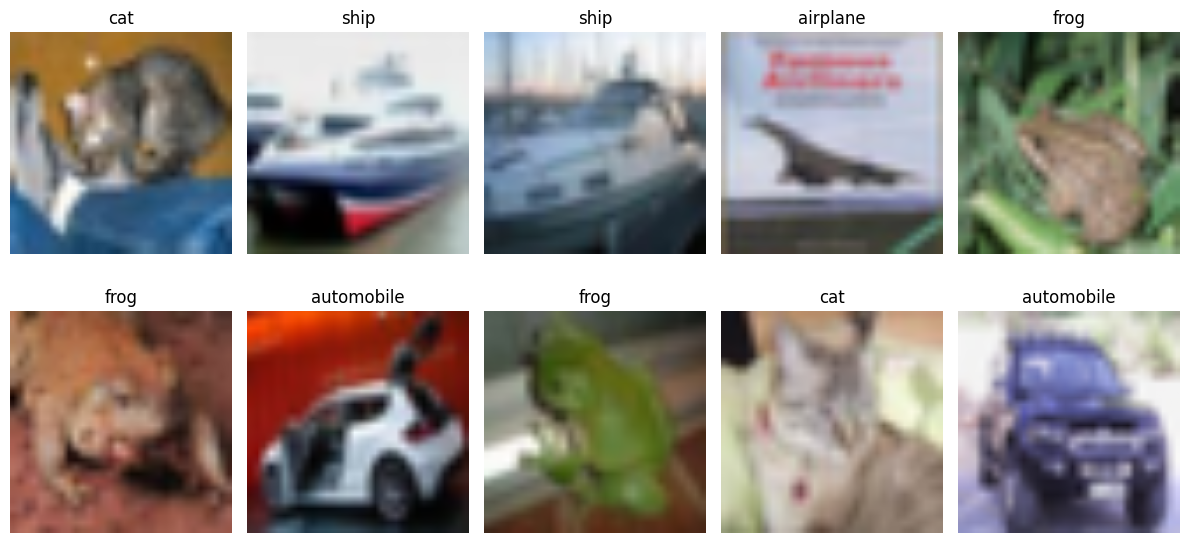

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Updated function to extract and plot images from tf.data.Dataset
def plot_sample_images_from_dataset(dataset, class_names):
    plt.figure(figsize=(12, 6))
    # Take one batch from the dataset
    for images, labels in dataset.take(1):
        images = images.numpy()
        labels = labels.numpy()
        for i in range(10):
            plt.subplot(2, 5, i + 1)
            plt.imshow(images[i])
            class_index = np.argmax(labels[i])
            plt.title(class_names[class_index])
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call it using val_ds
plot_sample_images_from_dataset(val_ds, class_names)


# Conclusion
 MobileNetV2 outperforms the custom CNN in terms of accuracy and training efficiency, thanks to:

Transfer learning from ImageNet.

Larger input size (160×160) which helps extract more meaningful features.

Fewer epochs needed to reach high performance.